# Нейросети и вероятностные модели

**Разработчик: Алексей Умнов**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw8/DL21-fall-shw8.ipynb)

In [56]:
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw8/utils.py"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw8/pixelcnn.png"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw8/mask_no_center.png"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw8/mask_with_center.png"

utils.py.1          100%[===================>]   2.10K  --.-KB/s    in 0s      
pixelcnn.png.1      100%[===================>]  15.16K  --.-KB/s    in 0s      
mask_no_center.png. 100%[===================>]     657  --.-KB/s    in 0s      
mask_with_center.pn 100%[===================>]     663  --.-KB/s    in 0s      


# Авторегрессионные модели

На этом семинаре мы поработаем с авторегрессионными моделями на примере архитектуры PixelCNN. Мы обучим модель для задачи генерации изображений и для задачи дорисовывания недостающих частей изображения.

### LCD digits dataset

В качестве примера мы возьмем датасет из простых LCD-цифр. Ниже приведен код, который его загружает и рисует примеры сэмплов.

Источник датасета: https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

In [57]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets, utils

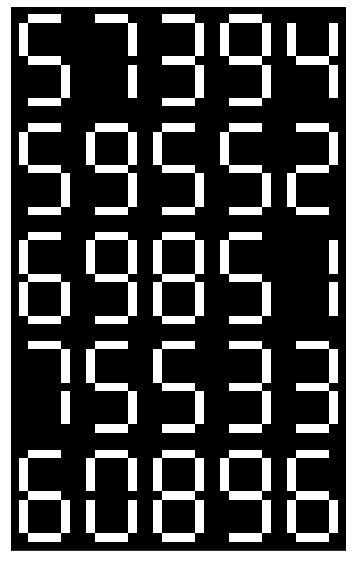

In [58]:
from utils import LcdDigits, IMAGE_WIDTH, IMAGE_HEIGHT

BATCH_SIZE = 100

train_dataset = LcdDigits(BATCH_SIZE * 50)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)


def show_as_image(image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.xticks([]); plt.yticks([])
    
def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

for batch, _ in train_loader:
    show_as_image(batch_images_to_one(batch[:25]), figsize=(10, 10))
    break

Здесь специально выбран простой датасет, так как вероятностные модели обычно требуют больших ресурсов. Также обратите внимание, что хотя данные очень простые (фактически всего 10 разных сэмплов), они находятся в пространстве значительно большей размерности ($2^{8 \times 13}$). Мы будем подавать модели сырые пиксели на вход, и будем хотеть, чтобы она нашла в них правильные зависимости и научилась строить только валидные изображения.

### PixelCNN

Коротко вспомним, что такое PixelCNN. Авторегрессионные модели в общем виде моделируют распределения на векторах $x = (x_1, \ldots, x_N)$ в виде:

$$
    p(x) = \prod_{i=1}^{N} p(x_i \mid x_1, \ldots, x_{i-1}).
$$

Распределения $p(x_i \mid x_1, \ldots, x_{i-1})$ можно моделировать при помощи нейронных сетей, которые получают на вход значения $x_1, \ldots, x_{i-1}$ и выдают распределение вероятностей для значений $x_i$. Так как входов здесь переменное число, можно использовать рекуррентные сети (например, PixelRNN), но неплохо работает и более простая модель &mdash; PixelCNN, &mdash; которая подает на вход не все значения $x_1, \ldots, x_{i-1}$, а только соседние на некотором расстоянии с помощью сверточных слоев.

![pixelcnn](https://github.com/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw8/pixelcnn.png?raw=1)

Для того, чтобы для данного пикселя подавать на вход только значения идущие ранее, вместо обычных сверток нужно использовать маскированные свертки. Напишите недостающий код, чтобы создать соответствующие маски и потом сделайте из них слой для pytorch. Такие слои можно добавлять последовательно, сохраняя корректные зависимости, при этом во всех слоях кроме первого можно использовать центральный пиксель. У вас должны получаться вот такие маски (с `include_center=False` и с `include_center=True` соответственно):

![](https://github.com/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw8/mask_with_center.png?raw=1)
![](https://github.com/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw8/mask_no_center.png?raw=1)

Hint: можно умножить на маску не входы, а веса.

In [59]:
def causal_mask(width, height, starting_point):
    
    # YOUR CODE
    ar = np.arange(width * height).reshape(height, width)
    sp = starting_point[0] * width + starting_point[1]
    mask = ar <= sp
    return mask

def conv_mask(height, width, include_center=False):
    return torch.tensor(1.0 * causal_mask(
        width, height, 
        starting_point=(height//2, width//2 + include_center - 1)))

In [60]:
class MaskedConv2d(nn.Module):
    def __init__(self, include_center, *args, **kwargs):
        super().__init__()
        ks = kwargs['kernel_size']
        self.register_buffer('mask', conv_mask(ks, ks, include_center=include_center))
        # self.mask = conv_mask(ks, ks, include_center=include_center)
        self.conv = nn.Conv2d(**kwargs)

    # YOUR CODE
    def forward(self, input):
      self.conv.weight.data *= self.mask
      return self.conv(input)
      # return super().forward(input)


Теперь соберите сеть с несколькими слоями маскированных сверток и обучите ее.

Hint 1: в задаче хорошо помогает сверточный слой 1x1 в конце.

Hint 2: если ошибиться и нарушить казуальность (т.е. сделать зависимости вперед), то обучаться будет хорошо, а генерировать плохо.

In [61]:
MaskedConv2d(include_center=False, in_channels=1, out_channels=4, kernel_size=5, padding=2)

MaskedConv2d(
  (conv): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [62]:
N_PIXELS_OUT = 2 # binary 0/1 pixels
class PixelCNN(nn.Module):
    
    def __init__(self, n_channels, kernel_size, padding):
        super().__init__()
    # YOUR CODE
        self.layers = nn.Sequential(*[
            # MaskedConv2d(1, n_channels, kernel_size, padding, include_center=False),
            MaskedConv2d(include_center=False, in_channels=1, out_channels=n_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(include_center=True, in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=N_PIXELS_OUT, kernel_size=1, padding=0),
            nn.BatchNorm2d(N_PIXELS_OUT)
        ])         
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

In [63]:
N_EPOCHS = 25
LR = 0.005

cnn = PixelCNN(n_channels=4, kernel_size=7, padding=3)
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

Обратите внимание, что полученной сети достаточно подать на вход изображение, и на выходе получится распределение для значений каждого пикселя. Осталось только минимизировать кросс-энтропию этих значений и пикселей примеров в выборке. В случае успеха итоговая кросс-энтропия будет около 0.02.

In [66]:
import torch.nn.functional as F



for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # YOUR CODE
        output = cnn(images)
        out = F.softmax(output)[:, 1, :, :].unsqueeze(1)
        loss = F.binary_cross_entropy(out, images)
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, N_EPOCHS, loss.data.item()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch [1/25], Loss: 0.7753
Epoch [2/25], Loss: 0.2488
Epoch [3/25], Loss: 0.1508
Epoch [4/25], Loss: 0.1136
Epoch [5/25], Loss: 0.0950
Epoch [6/25], Loss: 0.0855
Epoch [7/25], Loss: 0.0776
Epoch [8/25], Loss: 0.0733
Epoch [9/25], Loss: 0.0703
Epoch [10/25], Loss: 0.0679
Epoch [11/25], Loss: 0.0662
Epoch [12/25], Loss: 0.0647
Epoch [13/25], Loss: 0.0629
Epoch [14/25], Loss: 0.0616
Epoch [15/25], Loss: 0.0600
Epoch [16/25], Loss: 0.0555
Epoch [17/25], Loss: 0.0465
Epoch [18/25], Loss: 0.0444
Epoch [19/25], Loss: 0.0439
Epoch [20/25], Loss: 0.0433
Epoch [21/25], Loss: 0.0427
Epoch [22/25], Loss: 0.0420
Epoch [23/25], Loss: 0.0414
Epoch [24/25], Loss: 0.0411
Epoch [25/25], Loss: 0.0405


При генерации изображений можно начинать с пустого изображения, а можно подавать какие-то начальные пиксели. Допишите функцию генерации и проверьте ее для задачи генерации (на вход пустое изображения) и для задачи дорисовывания (на вход - верхняя часть изображения).

У вас должны получиться разумные изображения цифр, допускается небольшая доля "плохих" изображений.

*Упражнение:* почему при одинаковых пустых входных изображениях получаются разные изображения на выходе?

TypeError: ignored

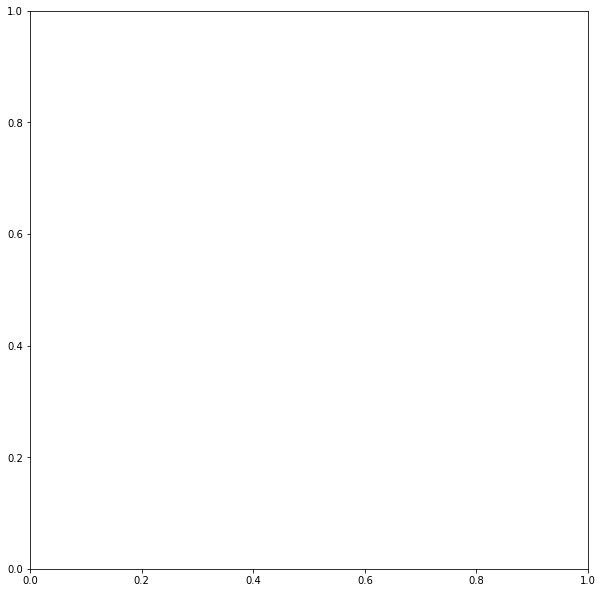

In [68]:
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else 
        np.zeros((n_samples * n_samples, 1, IMAGE_HEIGHT, IMAGE_WIDTH))).float()

    cnn.train(False)
    
    # YOUR CODE

    # Это не успел, сорян(
        
        
    out = cnn(samples).detach()
    
    return out.numpy()


show_as_image(batch_images_to_one(generate_samples(n_samples=10)), figsize=(10, 20))

In [ ]:
from utils import random_digits

n_images = 10
starting_point = (4, 3)

mask = causal_mask(IMAGE_HEIGHT, IMAGE_WIDTH, starting_point)

starting_images = digits_list = [random_digits(fixed_label=d)[0] for d in range(10)]
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(n_images, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(10, 10))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(10, 20))